# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

##### Описание тарифов 

  Тариф «Смарт» 
- Ежемесячная плата: 550 рублей 
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); - Cообщение: 3 рубля; 
- 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра» 

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

Примечание: 
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Посмотрю сначала вцелом что за данные в таблицах. Потом подробнее про каждую отдельно, через функцию мне не совсем удобно в плане наглядности.

In [3]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')

for i in [data_calls, data_internet, data_messages, data_tariffs, data_users]:
    print (i.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

<class 'pandas.core.fram

#По первому взгляду вижу пропуски в churn_date (но скорее всего по условиям значит, что тариф действующий). Поменять нужно тип в датах на временной. 

#### Описание данных
 Таблица users (информация о пользователях):  
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

Таблица calls (информация о звонках): 
 
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях): 
 
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях): 
 
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах): 
 
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [4]:
data_users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
data_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

#скорее всего поменяю потом reg_date, так как год один, а для анализа возможно понадобится значение месяца

In [6]:
data_calls.tail(15)

,id,call_date,duration,user_id
202592,1499_205,2018-10-13,0.00,1499
202593,1499_206,2018-12-26,0.00,1499
202594,1499_207,2018-10-28,0.00,1499
202595,1499_208,2018-11-03,14.29,1499
202596,1499_209,2018-12-16,0.00,1499
202597,1499_210,2018-10-02,8.86,1499
202598,1499_211,2018-12-29,4.58,1499
202599,1499_212,2018-12-30,1.35,1499
202600,1499_213,2018-10-17,10.77,1499
202601,1499_214,2018-12-05,2.42,1499


In [7]:
#какая доля 0 значений
data_calls[data_calls['duration'] == 0].count()[0]/data_calls.shape[0]

0.19551644316336553

In [8]:
len(data_calls['user_id'].unique()) #из 500 8 пользователей не разговаривали по телефону, что вполне возможно

492

#в соответсвии с условием задачи нужно округлить секунды до минут, а мегабайты — до гигабайт (далее). Id привязан к user_id. Нулевыx значений длительности 19%, предположим что это не сбой программы, так как даты подгрузились, и заменим на 1 (на среднее значение некорректно, так как это может повлиять на всю базу, возможно что был вызов в долях секунд)

In [9]:
data_messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
data_internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [11]:
data_internet['mb_used'].value_counts()

0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64

In [12]:
data_internet['mb_used'].nsmallest(5)

11    0.0
38    0.0
46    0.0
67    0.0
72    0.0
Name: mb_used, dtype: float64

In [13]:
#какая доля 0 значений
data_internet[data_internet['mb_used'] == 0].count()[0]/data_internet.shape[0]

0.13118155773916304

#много нулей в сессиях, это или ошибка, или пользователь не пользовался интернетом совсем (что вряд ли, так как дата сессии зафиксировалась, а мегалайн увеличивет в большую сторону интернет). Данные скорее всего в мгб, привести нужно к округлению и 0 заменить на 1

In [14]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод
Обнаружны нулевые значения в звонках и сессиях (mb_used, duration),  также нужно исправить тип в duration, mb_used после округления на int,  в датах и перевести в удобный читаемый формат. Далее объединить данные. В data_internet странный столбец, дублирующий индекс, не нужен для задачи.

## Предобработка данных

In [15]:
#изменяем тип данных в датах
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')

In [16]:
data_internet['mb_used'] = np.ceil(data_internet['mb_used']).astype('int')
data_calls['duration'] = data_calls['duration'].astype('int')

In [17]:
data_internet.loc[data_internet['mb_used'] == 0, 'mb_used'] = 1

In [18]:
data_calls['duration'].value_counts().head(5)

0    47927
6    11509
5    11457
4    11405
7    11268
Name: duration, dtype: int64

In [19]:
data_internet['mb_used'].value_counts().head(5)

1      19700
333      231
382      228
377      224
253      222
Name: mb_used, dtype: int64

In [20]:
data_internet['mb_used'].describe() #проверю для себя реальность

count    149396.000000
mean        370.753280
std         278.212524
min           1.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64

In [21]:
#сделаем столбец месяца
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month

In [22]:
data_calls.head(5)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,2,1000,6
3,1000_3,2018-09-21,13,1000,9
4,1000_4,2018-12-15,5,1000,12


In [23]:
# рассмотрим количество сделанных звонков и израсходованных минут по месяцам
data_calls_pivot = data_calls.pivot_table(index=['user_id', 'month'], values= ['duration'], aggfunc=['sum', 'count'])
data_calls_pivot.columns = ['total_calls', 'count_calls']

data_calls_pivot

total_calls  count_calls
user_id month                          
1000    5              142           22
        6              144           43
        7              299           47
        8              367           52
        9              421           58
...                    ...          ...
1498    10             218           41
1499    9               62            9
        10             406           68
        11             550           74
        12             436           69

[3174 rows x 2 columns]

In [24]:
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month

In [25]:
data_messages_pivot = data_messages.pivot_table(index=['user_id', 'month'], values= 'id', aggfunc='count')
data_messages_pivot.columns = ['count_message']

data_messages_pivot

count_message
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
...                      ...
1498    10                42
1499    9                 11
        10                48
        11                59
        12                66

[2717 rows x 1 columns]

In [26]:
# рассмотрим объем израсходованного интернет-трафика по месяцам
data_internet_pivot = data_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['sum'])
data_internet_pivot.columns = ['traffic_total']

data_internet_pivot

traffic_total
user_id month               
1000    5               2257
        6              23262
        7              14017
        8              14072
        9              14583
...                      ...
1498    10             20614
1499    9               1849
        10             17824
        11             17994
        12             13082

[3203 rows x 1 columns]

In [27]:
# объединим таблицы для расчета ежемесячной выручки и дальнейшего анализа
# сформируем таблицу, содержащую информацию о количестве звонков, сообщений и объеме интернета
megaline_traf = pd.merge(data_messages_pivot, data_calls_pivot, on= ['user_id', 'month'], how='outer')
megaline_traf = pd.merge(megaline_traf,data_internet_pivot, on= ['user_id', 'month'], how='outer' )
megaline_traf = megaline_traf.reset_index()
megaline_traf 


,user_id,month,count_message,total_calls,count_calls,traffic_total
0,1000,5,22.0,142.0,22.0,2257.0
1,1000,6,60.0,144.0,43.0,23262.0
2,1000,7,75.0,299.0,47.0,14017.0
3,1000,8,81.0,367.0,52.0,14072.0
4,1000,9,57.0,421.0,58.0,14583.0
...,...,...,...,...,...,...
3209,1494,9,NaN,444.0,66.0,16993.0
3210,1494,10,NaN,309.0,52.0,17799.0
3211,1494,11,NaN,367.0,63.0,18083.0
3212,1494,12,NaN,364.0,62.0,17650.0


In [28]:
all_users = data_users.loc[:,['user_id', 'city', 'tariff']] #все остальное типа имен мне не потребуется (были бы номера телефонов по нима можно было бы тоже проверить)

In [29]:
megaline_traf  = pd.merge(megaline_traf, all_users, on= ['user_id'], how = 'outer' )
megaline_traf.reset_index(drop=True)
megaline_traf 

,user_id,month,count_message,total_calls,count_calls,traffic_total,city,tariff
0,1000,5.0,22.0,142.0,22.0,2257.0,Краснодар,ultra
1,1000,6.0,60.0,144.0,43.0,23262.0,Краснодар,ultra
2,1000,7.0,75.0,299.0,47.0,14017.0,Краснодар,ultra
3,1000,8.0,81.0,367.0,52.0,14072.0,Краснодар,ultra
4,1000,9.0,57.0,421.0,58.0,14583.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3211,1494,10.0,NaN,309.0,52.0,17799.0,Омск,smart
3212,1494,11.0,NaN,367.0,63.0,18083.0,Омск,smart
3213,1494,12.0,NaN,364.0,62.0,17650.0,Омск,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra


In [30]:
megaline_traf['user_id'].nunique() #проверю что все на месте

500

### Вывод
Вцелом значения не требуют особой обработки, кажутся вполне реальными. Заполнены нулевые значения в duration и mb_used, приведены типы данных. Разбиты месяца. Сформированна таблица со всеми данными по пользователям.В churn_date часть значений отсутсвует (по условиям значит тариф еще действет),  и NaN в звонках

## Расчёты и добавление результатов в таблицу

#### задача посчитать выручку:

Для каждого пользователя посчитаем:
- помесячную выручку (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану)

#заменю Nan на 0
megaline_traf.isna().sum()

In [31]:
megaline_traf[megaline_traf['month'].isna()]

,user_id,month,count_message,total_calls,count_calls,traffic_total,city,tariff
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,Омск,smart


2 абонента которые не звонили, не заходили в интернет и никак не пользовались услугами, удалим их,  или можно поставить им 12 месяц как новым пользователям (возможно они поэтому не пользовались пока услугами)

In [32]:
megaline_traf = megaline_traf.dropna(subset=['month'])
megaline_traf

,user_id,month,count_message,total_calls,count_calls,traffic_total,city,tariff
0,1000,5.0,22.0,142.0,22.0,2257.0,Краснодар,ultra
1,1000,6.0,60.0,144.0,43.0,23262.0,Краснодар,ultra
2,1000,7.0,75.0,299.0,47.0,14017.0,Краснодар,ultra
3,1000,8.0,81.0,367.0,52.0,14072.0,Краснодар,ultra
4,1000,9.0,57.0,421.0,58.0,14583.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3209,1494,8.0,NaN,237.0,32.0,6607.0,Омск,smart
3210,1494,9.0,NaN,444.0,66.0,16993.0,Омск,smart
3211,1494,10.0,NaN,309.0,52.0,17799.0,Омск,smart
3212,1494,11.0,NaN,367.0,63.0,18083.0,Омск,smart


In [33]:
pd.set_option('chained_assignment', None)
megaline_traf.loc[:,['count_message', 'total_calls', 'count_calls', 'traffic_total']] = megaline_traf.loc[:,['count_message', 'total_calls', 'count_calls', 'traffic_total']].fillna(0)

In [34]:
megaline_traf.isna().sum()

user_id          0
month            0
count_message    0
total_calls      0
count_calls      0
traffic_total    0
city             0
tariff           0
dtype: int64

In [35]:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [36]:
#у каждого пользователя есть тариф. Он по нему платит, иногда он платит больше. Напишу функцию (вычесть бесплатный лимит и умножить на трафик)
def salary_month(row):
    
    if row['tariff']=='smart':
        cost_calls = (row['total_calls'] - data_tariffs.loc[0,'minutes_included']) * data_tariffs.loc[0,'rub_per_minute']
        if cost_calls < 0: cost_calls = 0
        cost_message = (row['count_message'] - data_tariffs.loc[0,'messages_included']) * data_tariffs.loc[0,'rub_per_message']
        if cost_message < 0 : cost_message = 0
        
        cost_mb  = ((row['traffic_total'] - data_tariffs.loc[0,'mb_per_month_included'])/1024) * data_tariffs.loc[0,'rub_per_gb'] 
        if cost_mb < 0 : cost_mb = 0
        
        cost = cost_calls + cost_message + cost_mb + data_tariffs.loc[0,'rub_monthly_fee']
    elif row['tariff']=='ultra':
        cost_calls = (row['total_calls'] - data_tariffs.loc[1,'minutes_included']) * data_tariffs.loc[1,'rub_per_minute']
        if cost_calls < 0:
            cost_calls = 0
        cost_message = (row['count_message'] - data_tariffs.loc[1,'messages_included']) * data_tariffs.loc[1,'rub_per_message']
        if cost_message < 0 : cost_message = 0
        
        cost_mb  = ((row['traffic_total'] - data_tariffs.loc[1,'mb_per_month_included'])/1024) * data_tariffs.loc[1,'rub_per_gb'] 
        if cost_mb < 0 : cost_mb = 0
        
        cost = cost_calls + cost_message + cost_mb + data_tariffs.loc[1,'rub_monthly_fee']
   

    return cost

megaline_traf['profit'] = megaline_traf.apply(salary_month, axis=1)



In [37]:
megaline_traf

,user_id,month,count_message,total_calls,count_calls,traffic_total,city,tariff,profit
0,1000,5.0,22.0,142.0,22.0,2257.0,Краснодар,ultra,1950.000000
1,1000,6.0,60.0,144.0,43.0,23262.0,Краснодар,ultra,1950.000000
2,1000,7.0,75.0,299.0,47.0,14017.0,Краснодар,ultra,1950.000000
3,1000,8.0,81.0,367.0,52.0,14072.0,Краснодар,ultra,1950.000000
4,1000,9.0,57.0,421.0,58.0,14583.0,Краснодар,ultra,1950.000000
...,...,...,...,...,...,...,...,...,...
3209,1494,8.0,0.0,237.0,32.0,6607.0,Омск,smart,550.000000
3210,1494,9.0,0.0,444.0,66.0,16993.0,Омск,smart,868.945312
3211,1494,10.0,0.0,309.0,52.0,17799.0,Омск,smart,1026.367188
3212,1494,11.0,0.0,367.0,63.0,18083.0,Омск,smart,1081.835938


#странная ошибка вышла у функции, но столбец с выручкой появился 

In [38]:
megaline_traf['traffic_total'] = np.ceil(megaline_traf['traffic_total']/1000)

In [39]:
megaline_traf

,user_id,month,count_message,total_calls,count_calls,traffic_total,city,tariff,profit
0,1000,5.0,22.0,142.0,22.0,3.0,Краснодар,ultra,1950.000000
1,1000,6.0,60.0,144.0,43.0,24.0,Краснодар,ultra,1950.000000
2,1000,7.0,75.0,299.0,47.0,15.0,Краснодар,ultra,1950.000000
3,1000,8.0,81.0,367.0,52.0,15.0,Краснодар,ultra,1950.000000
4,1000,9.0,57.0,421.0,58.0,15.0,Краснодар,ultra,1950.000000
...,...,...,...,...,...,...,...,...,...
3209,1494,8.0,0.0,237.0,32.0,7.0,Омск,smart,550.000000
3210,1494,9.0,0.0,444.0,66.0,17.0,Омск,smart,868.945312
3211,1494,10.0,0.0,309.0,52.0,18.0,Омск,smart,1026.367188
3212,1494,11.0,0.0,367.0,63.0,19.0,Омск,smart,1081.835938


#### Задача. 
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [40]:
#посмотрим тариф смарт
#Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц
megaline_traf_smart = megaline_traf.query('tariff=="smart"').groupby(['tariff', 'month'])['count_message', 'total_calls', 'traffic_total', 'profit'].sum().reset_index()

In [41]:
megaline_traf_smart

,tariff,month,count_message,total_calls,traffic_total,profit
0,smart,1.0,620.0,6198.0,307.0,23759.460938
1,smart,2.0,1397.0,15453.0,702.0,44888.265625
2,smart,3.0,2453.0,26691.0,1200.0,82136.421875
3,smart,4.0,3443.0,36518.0,1562.0,98710.570312
4,smart,5.0,4762.0,48444.0,2306.0,155301.617188
5,smart,6.0,5478.0,57667.0,2673.0,180659.570312
6,smart,7.0,6784.0,72960.0,3270.0,223983.507812
7,smart,8.0,7905.0,88051.0,4033.0,282645.046875
8,smart,9.0,8746.0,99061.0,4374.0,295957.898438
9,smart,10.0,9927.0,111379.0,5078.0,365781.976562


In [42]:
megaline_traf_smart['profit'].sum()

2619037.1484375

In [43]:
megaline_traf_ultra = megaline_traf.query('tariff=="ultra"').groupby(['tariff', 'month'])['count_message', 'total_calls', 'traffic_total', 'profit'].sum().reset_index()
megaline_traf_ultra

,tariff,month,count_message,total_calls,traffic_total,profit
0,ultra,1.0,304.0,3439.0,123.0,17550.000000
1,ultra,2.0,527.0,6320.0,293.0,47354.296875
2,ultra,3.0,1195.0,16129.0,670.0,74157.421875
3,ultra,4.0,1736.0,22357.0,953.0,109751.074219
4,ultra,5.0,2536.0,30352.0,1333.0,137686.523438
5,ultra,6.0,3505.0,35799.0,1634.0,170697.216797
6,ultra,7.0,4536.0,44143.0,1914.0,191879.150391
7,ultra,8.0,5183.0,48565.0,2146.0,221621.630859
8,ultra,9.0,6013.0,55146.0,2269.0,231584.326172
9,ultra,10.0,7187.0,61009.0,2528.0,253007.958984


In [44]:
megaline_traf_ultra['profit'].sum()

2029682.51953125

In [45]:
megaline_traf_ultra['profit'].sum()/megaline_traf_smart['profit'].sum() #посмотреть на сколько больше выручка с смарта

0.7749727875154978

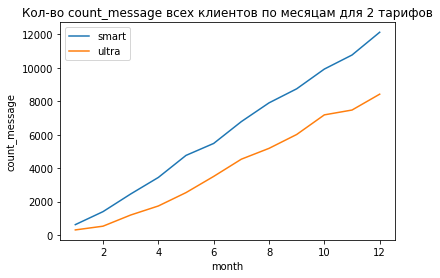

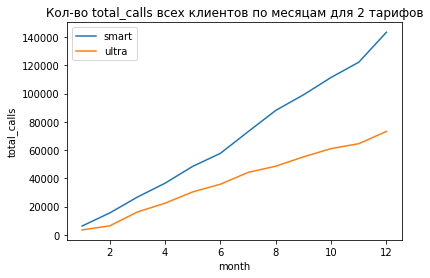

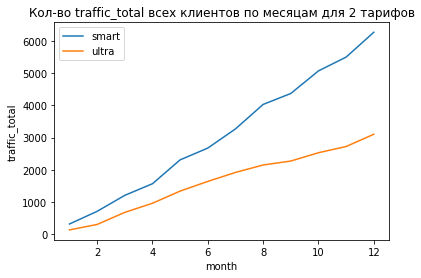

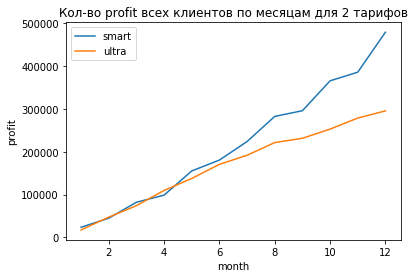

In [46]:
for i in ['count_message', 'total_calls', 'traffic_total', 'profit']:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(megaline_traf_smart['month'], megaline_traf_smart[i], color='tab:blue', label='smart')
    ax.plot(megaline_traf_ultra['month'], megaline_traf_ultra[i], color='tab:orange',label='ultra' )
    plt.xlabel('month')
    plt.ylabel(i)
    plt.title(f'Кол-во {i} всех клиентов по месяцам для 2 тарифов')
    plt.legend()
    plt.show();

Посмотрим на гистограммах частоту распределения клиентов по объему использования услуг

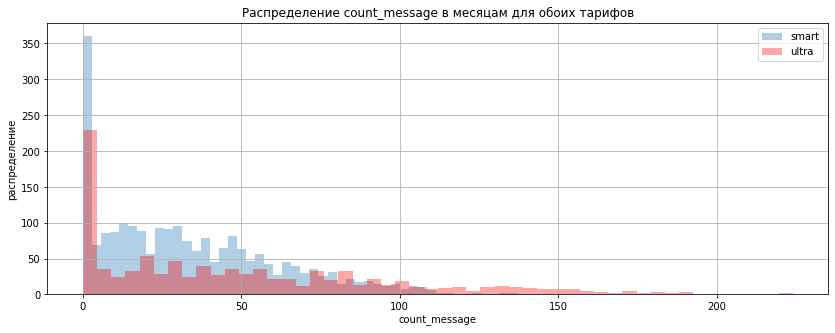

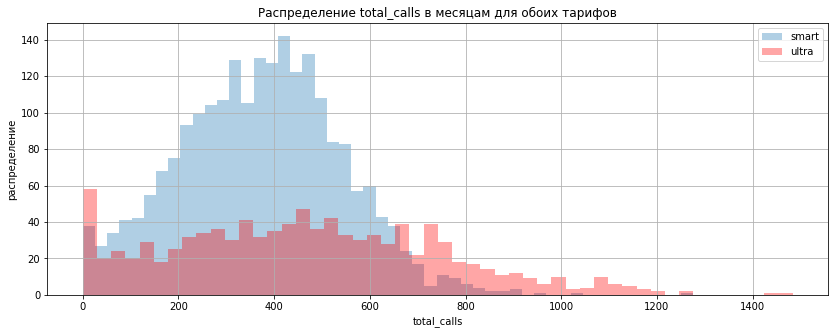

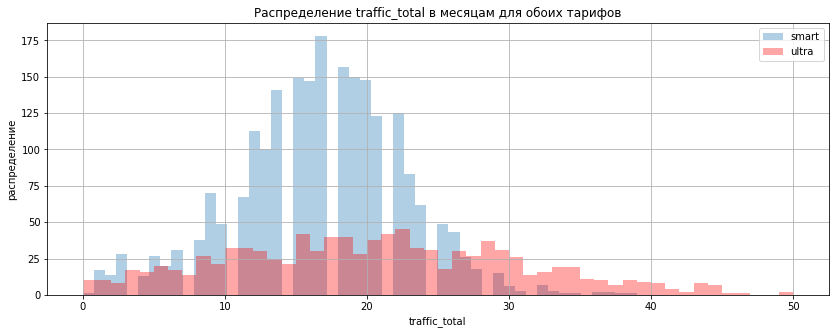

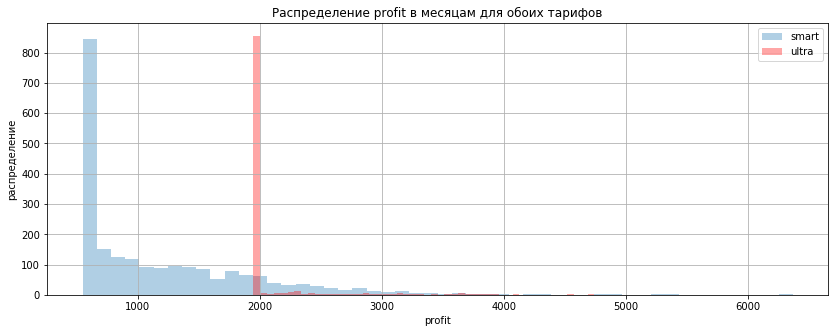

In [47]:
for i in ['count_message', 'total_calls', 'traffic_total', 'profit']:
    plt.figure(figsize=(14, 5))
    
    plt.hist(megaline_traf.loc[megaline_traf['tariff'] == "smart", i], label='smart', alpha=0.35, bins = 50)
    plt.hist(megaline_traf.loc[megaline_traf['tariff'] == "ultra", i], label='ultra', color='r', alpha=0.35, bins = 50)
    
    plt.ylabel('распределение')
    plt.xlabel(i)
    plt.grid()
    plt.title(f'Распределение {i} в месяцам для обоих тарифов')
    plt.legend()
    plt.show();

###### Вывод:
Минут разговора, число сообщений и объем потраченного интернет-трафика по тарифу смарт больше чем ультра,особенно на крайних месяцах, что логично - так как у тарифа больше пользователей и он более дешевый.  Выручка в первой половине года почти равно, а во второй - абоненты smart с каждым месяцем приносят выручки все больше. В ультра включено больше минут, гб и сообщений, поэтому распределение выручки более однотипное, равное оплате тарифа. Мало пользователей, кто использует сообщения (что логично, больше пользуются интернетом).  Далее будем смотреть средние.

In [48]:
megaline_traf_smart.describe()

,month,count_message,total_calls,traffic_total,profit
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,6.500000,6201.083333,68995.750000,3107.916667,218253.095703
std,3.605551,3790.989687,44356.455341,1970.169511,145947.480569
min,1.000000,620.000000,6198.000000,307.000000,23759.460938
25%,3.750000,3195.500000,34061.250000,1471.500000,94567.033203
50%,6.500000,6131.000000,65313.500000,2971.500000,202321.539062
75%,9.250000,9041.250000,102140.500000,4550.000000,313413.917969
max,12.000000,12130.000000,143373.000000,6282.000000,479260.570312


In [49]:
#найдем средннее по месяцам для интереса
tariffs_mean = megaline_traf.groupby([ 'tariff', 'month'])['count_message', 'total_calls', 'traffic_total', 'profit'].mean().reset_index()

In [50]:
tariffs_mean

,tariff,month,count_message,total_calls,traffic_total,profit
0,smart,1.0,18.235294,182.294118,9.029412,698.807675
1,smart,2.0,24.086207,266.431034,12.103448,773.935614
2,smart,3.0,31.857143,346.636364,15.584416,1066.706778
3,smart,4.0,30.741071,326.053571,13.946429,881.344378
4,smart,5.0,33.773050,343.574468,16.354610,1101.429909
5,smart,6.0,33.402439,351.628049,16.298780,1101.582746
6,smart,7.0,33.751244,362.985075,16.268657,1114.345810
7,smart,8.0,33.638298,374.685106,17.161702,1202.744880
8,smart,9.0,33.638462,381.003846,16.823077,1138.299609
9,smart,10.0,33.765306,378.840136,17.272109,1244.156383


In [51]:
tariffs_smart = tariffs_mean.query(' tariff=="smart" ')
tariffs_smart #разделим по тарифам для интереса (в рамках задачи не требуется, просто попробовать)

,tariff,month,count_message,total_calls,traffic_total,profit
0,smart,1.0,18.235294,182.294118,9.029412,698.807675
1,smart,2.0,24.086207,266.431034,12.103448,773.935614
2,smart,3.0,31.857143,346.636364,15.584416,1066.706778
3,smart,4.0,30.741071,326.053571,13.946429,881.344378
4,smart,5.0,33.773050,343.574468,16.354610,1101.429909
5,smart,6.0,33.402439,351.628049,16.298780,1101.582746
6,smart,7.0,33.751244,362.985075,16.268657,1114.345810
7,smart,8.0,33.638298,374.685106,17.161702,1202.744880
8,smart,9.0,33.638462,381.003846,16.823077,1138.299609
9,smart,10.0,33.765306,378.840136,17.272109,1244.156383


In [52]:
tariffs_ultra = tariffs_mean.query(' tariff=="ultra" ').reset_index()
tariffs_ultra

,index,tariff,month,count_message,total_calls,traffic_total,profit
0,12,ultra,1.0,33.777778,382.111111,13.666667,1950.000000
1,13,ultra,2.0,21.958333,263.333333,12.208333,1973.095703
2,14,ultra,3.0,32.297297,435.918919,18.108108,2004.254645
3,15,ultra,4.0,31.563636,406.490909,17.327273,1995.474077
4,16,ultra,5.0,37.850746,453.014925,19.895522,2055.022738
5,17,ultra,6.0,41.726190,426.178571,19.452381,2032.109724
6,18,ultra,7.0,49.846154,485.087912,21.032967,2108.562092
7,19,ultra,8.0,48.439252,453.878505,20.056075,2071.230195
8,20,ultra,9.0,52.286957,479.530435,19.730435,2013.776749
9,21,ultra,10.0,58.430894,496.008130,20.552846,2056.975276


tariffs_ultra = tariffs_ultra.pivot_table(index=['tariff'], values=['count_message', 'total_calls', 'traffic_total'], 
                    aggfunc={'count_message': [np.median, np.var, np.std], 
                             'total_calls': [np.median, np.var, np.std], 
                             'traffic_total': [np.median, np.var, np.std]})
tariffs_ultra

In [53]:
#найдем средннее вцелом
tariffs_mean_year = megaline_traf.groupby([ 'tariff'])['count_message', 'total_calls', 'traffic_total', 'profit'].mean().reset_index()

In [54]:
tariffs_mean_year#найдем средннее вцелом
tariffs_mean_year = megaline_traf.groupby([ 'tariff'])['count_message', 'total_calls', 'traffic_total', 'profit'].mean().reset_index()
tariffs_mean_year

,tariff,count_message,total_calls,traffic_total,profit
0,smart,33.384029,371.444145,16.731718,1174.983019
1,ultra,49.363452,467.923858,19.988832,2060.591390


In [55]:
#найдем медиану вцелом 
tariffs_median_year = megaline_traf.groupby([ 'tariff'])['count_message', 'total_calls', 'traffic_total', 'profit'].median().reset_index()

In [56]:
tariffs_median_year

,tariff,count_message,total_calls,traffic_total,profit
0,smart,28.0,375.0,17.0,894.921875
1,ultra,38.0,458.0,20.0,1950.000000


In [57]:
count_message_var_year = np.var(megaline_traf['count_message'], ddof=1)

In [58]:
count_message_var_year

1306.7014417742485

In [59]:
tariffs_var_year =round(megaline_traf.groupby([ 'tariff'])['count_message', 'total_calls', 'traffic_total', 'profit'].var(ddof=1).reset_index(), 1)


In [60]:
tariffs_var_year #дисперсия по тарифам

,tariff,count_message,total_calls,traffic_total,profit
0,smart,796.8,28860.9,34.7,569618.5
1,ultra,2285.3,79896.9,102.3,127041.1


In [61]:
tariffs_std_year = round(np.sqrt(megaline_traf.groupby([ 'tariff'])['count_message', 'total_calls', 'traffic_total', 'profit'].var(ddof=1)).reset_index())

In [62]:
tariffs_std_year #стандартное отклонение по тарифам

,tariff,count_message,total_calls,traffic_total,profit
0,smart,28.0,170.0,6.0,755.0
1,ultra,48.0,283.0,10.0,356.0


#еще раз проверю прошлые графики
for i in ['count_message', 'total_calls', 'traffic_total', 'profit']:
    sns.catplot(data=tariffs_std_year, kind = 'box',  y=i, x='tariff')

Видно что стандартное отклонение тарифа smart меньше везде, кроме показателя выручки. 

for i in ['count_message', 'total_calls', 'traffic_total', 'profit']:
    sns.catplot(data=tariffs_median_year, kind = 'box',  y=i, x='tariff')

##### комментарий:
Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт», и медианы  также смещены в большую сторону, выбросов в рамках более дешевого тарифа существенно больше.

##### Вывод:
Пользователи обоих тарифов укладываются в среднем в пакетные значения, в тарифе ультра даже тратят меньше минут на звонки, чем входит в тариф (что для выручки хорошо). В сообщениях также пользователи укладываются в лимиты, используют эту опцию мало. В интернете пользователи смарта в среднем превышают лимит, в середине года используют чуть больше, чем в начале (думаю зависит от подключения, так как после первого квартала постепенный рост идет).  Поэтому пользователи тарифа ультра остаются в рамках лимита в части оплаты, а пользователи тарифа смарт доплачивают за тариф, чаще всего за интернет, которого им не хватает в рамках лимита.


## Гипотезы

#### задача проверить гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
- Пороговое значение alpha задать самостоятельно.

 Пояснить:
- как  формулировали нулевую и альтернативную гипотезы;
- какой критерий использовался для проверки гипотез и почему.

##### Гипотеза №1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
Так как "H₀ всегда формулируется так, чтобы использовать знак равенства" то:

 H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт»  равны; 
 
 H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
 
 alpha = 0.05

#теория для меня: В Python есть специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2,equal_var). Дисперсии рассматриваемых генеральных совокупностей должны быть равны.
Это коварное условие. С одной стороны, вы никогда точно не знаете, равны ли дисперсии рассматриваемых генеральных совокупностей. С другой — по умолчанию параметр equal_var принимает значение True: дисперсии считаются равными и тест объединяет обе выборки в одну, чтобы эту дисперсию поточнее оценить.

In [63]:
tariffs_var_year

,tariff,count_message,total_calls,traffic_total,profit
0,smart,796.8,28860.9,34.7,569618.5
1,ultra,2285.3,79896.9,102.3,127041.1


#дисперсии выручки отличаются, поэтому применяю equal_var = False

In [64]:
tariffs_smart_result = tariffs_smart['profit'].values
tariffs_smart_result

array([ 698.80767463,  773.93561422, 1066.7067776 ,  881.34437779,
       1101.42990913, 1101.58274581, 1114.34581001, 1202.74488032,
       1138.29960938, 1244.15638287, 1221.36785502, 1422.13819084])

In [65]:
tariffs_ultra_result = tariffs_ultra['profit'].values
tariffs_ultra_result

array([1950.        , 1973.09570312, 2004.25464527, 1995.4740767 ,
       2055.02273787, 2032.10972377, 2108.5620922 , 2071.23019495,
       2013.77674932, 2056.9752763 , 2080.85099405, 2126.32292603])

In [66]:
alpha = 0.05

results = st.ttest_ind(tariffs_smart_result, tariffs_ultra_result, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.3803351009411774e-09
Отвергаем нулевую гипотезу


Так как нулевую гипотезу отвергли, получается подтверждаем, что тариф ультра и смарт различаются.А значит доходы компании по двум тарифам различаются.

In [67]:
tariffs_smart_result_new = megaline_traf.query('tariff=="smart"')['profit']
tariffs_smart_result_new

8        550.000000
9        990.429688
10      1525.976562
11       816.406250
12       550.000000
           ...     
3209     550.000000
3210     868.945312
3211    1026.367188
3212    1081.835938
3213     997.265625
Name: profit, Length: 2229, dtype: float64

In [68]:
tariffs_ultra_result_new = megaline_traf.query('tariff=="ultra"')['profit']
tariffs_ultra_result_new

0       1950.000000
1       1950.000000
2       1950.000000
3       1950.000000
4       1950.000000
           ...     
3198    2294.384766
3199    2390.478516
3200    2345.654297
3201    2655.322266
3202    1950.000000
Name: profit, Length: 985, dtype: float64

In [69]:
alpha = 0.05

results = st.ttest_ind(tariffs_ultra_result_new, tariffs_smart_result_new, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


##### Гипотеза №2: средняя выручка пользователей Москвы и регионов

H0 — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

H1 — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

alpha = 0.05

In [70]:
moscow_profit_result = megaline_traf.query('city == "Москва"')['profit'].values
other_profit_result = megaline_traf.query('city != "Москва"')['profit'].values


In [71]:
moscow_profit_result

array([1950.        , 1950.        , 1950.        , 1950.        ,
       1950.        ,  550.        , 1011.1328125 ,  550.        ,
        677.84375   , 1598.6328125 ,  814.        ,  550.        ,
        792.515625  ,  550.        ,  841.        ,  556.        ,
        550.        , 1947.9921875 , 2690.9609375 , 1531.796875  ,
       2503.5       , 1724.7890625 ,  768.9453125 ,  550.        ,
        869.140625  , 2854.21875   ,  550.        ,  550.        ,
       1635.7421875 , 2008.7890625 ,  550.        ,  550.        ,
        550.        , 1950.        , 1950.        , 1950.        ,
       1950.        , 1950.        , 1950.        , 1950.        ,
       1950.        , 1950.        , 1950.        ,  550.        ,
        550.        , 1387.4453125 , 2422.0234375 , 3194.9296875 ,
       2027.7734375 , 1645.671875  , 2339.8828125 , 3123.8046875 ,
       1701.2578125 , 2008.4296875 ,  550.        ,  550.        ,
        619.        ,  796.        ,  589.        ,  550.     

In [72]:
other_profit_result

array([1950.       , 1950.       , 1950.       , ..., 1026.3671875,
       1081.8359375,  997.265625 ])

In [73]:
 np.var(moscow_profit_result)

544697.9925375014

In [74]:
 np.var(other_profit_result)

613382.6225168307

In [75]:
alpha = 0.05

results = st.ttest_ind(moscow_profit_result, other_profit_result)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3868632726686817
Не получилось отвергнуть нулевую гипотезу


Для меня стало открытием, но в соответствии с тестом получается, что вторая гипотеза не подтверждается. Значит доходы в Москве не особо отличаются от доходов в других регионах (по хорошему в реальной практике все же кажется, что есть смысл разделить на мск + питер, милионники и другие).

## Общий вывод

По результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт» в среднем, но и тариф ультра дороже.
Пользователи обоих тарифов укладываются в среднем в лимиты пакетов, в тарифе ультра даже тратят меньше минут на звонки, чем входит в тариф (что для выручки хорошо). В сообщениях также пользователи укладываются в лимиты, при этом  используют эту опцию мало. С интернетом несколько другая картина - пользователи смарта выходят за предедлы лимита и доплачивают сверх тарифа. Даже если бы средний пользователь перешел с тарифа ультра на смарт, то в итоге платил бы меньше, чем стоит пакет ультра. 
Пользователей тарифа смарт больше, возможно поэтому выручка оказалась больше ~30%, и можно было бы рекомендовать продвижение тарифа смарт, но в данном случае не учитываются затраты на обслуживание. Так как меньшее количество пользователей с более дорогим тарифом требует меньше вложений в обслуживание, и если увеличить с помощью продвижения долю абонентов тарифа ультра, вполне можно проверить гипотезу, что выручка будет больше (а  если подтвердится гипотеза с городами милионниками, то есть смысл делить тарифы в зависимости от гео). Пока что по имеющимся данным средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима.